### MLMetrics() contains metrics to calculate error rate


In [ ]:
install.packages("forecast")
install.packages("MLmetrics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’




In [ ]:
library(forecast)
library(MLmetrics)
data <- AirPassengers

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




In [ ]:
data

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336
1958,340,318,362,348,363,435,491,505,404,359,310,337


In [ ]:
#Training and validation sets
# you can use window() to cut off a time series
training <- window(data, start = c(1949,1), end = c(1955,12))
validation=window(data, start = c(1956,1))

In [ ]:
# snaive() does simple naive forecasting (NOTE: it can take seasonality into considereation)
naive = snaive(training, h=length(validation))
# Mean Absolute Percentage Error
MAPE(naive$mean, validation) * 100  # MAPE comes from MLMetrics() function

[1] 27.04689

27% of the time we're making an error

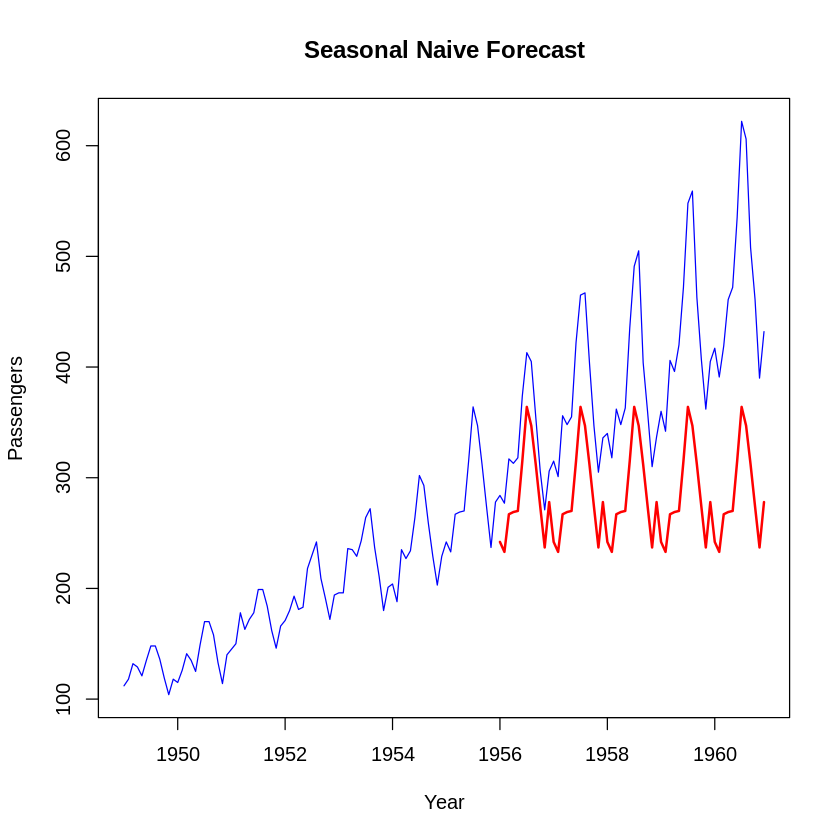

In [ ]:
# blue is actual data
# forecasted data
plot(data, col="blue", xlab="Year", ylab="Passengers", main="Seasonal Naive Forecast", type='l')
lines(naive$mean, col="red", lwd=2)

In [ ]:
# Double Seasonal Holt-Winters (DSKW) allows for 2 seasonalities
# gamma = TRUE is the seasonality
# beta = TRUE is the trend (positive, negative, straight)
ses <- HoltWinters(training, beta=FALSE, gamma=FALSE)

In [ ]:
summary(ses)

             Length Class  Mode     
fitted       166    mts    numeric  
x             84    ts     numeric  
alpha          1    -none- numeric  
beta           1    -none- logical  
gamma          1    -none- logical  
coefficients   1    -none- numeric  
seasonal       1    -none- character
SSE            1    -none- numeric  
call           4    -none- call     

In [ ]:
ses <- forecast(training, h=length(validation))

In [ ]:
MAPE(ses$mean, validation) * 100

[1] 11.36888

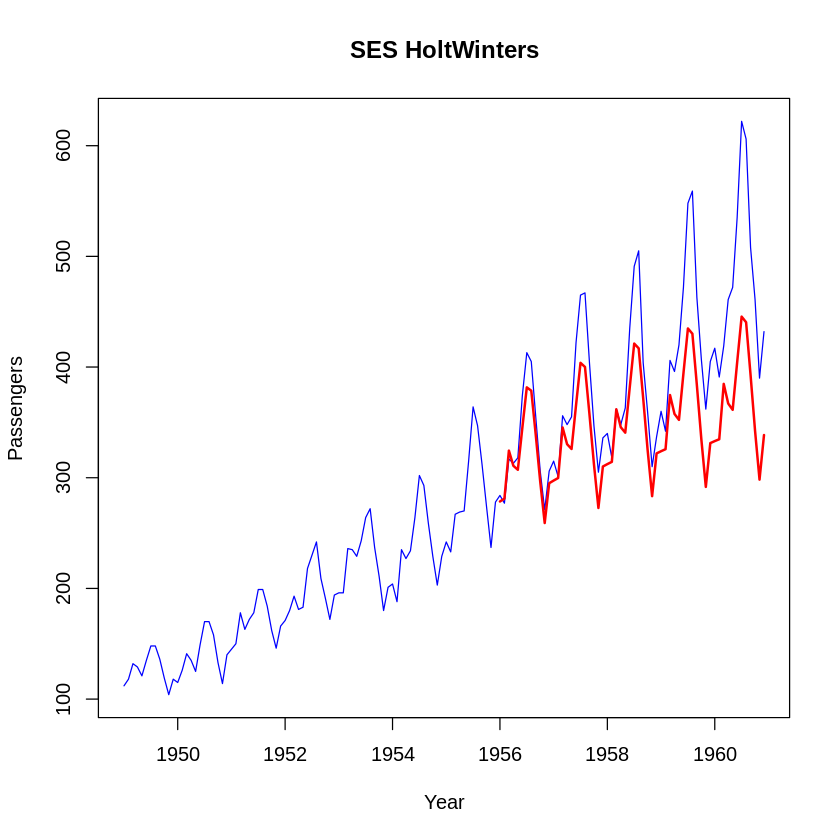

In [ ]:
plot(data, col="blue", xlab="Year", ylab="Passengers", main="SES HoltWinters", type='l')
lines(ses$mean, col="red", lwd=2)

Forecast is better, but still not accounting for trend

In [ ]:
# ets() generalizes all the methods with the optimal smoothing model
ets_model <- ets(training, allow.multiplicative.trend = TRUE)
summary(ets_model)


ETS(M,Md,M) 

Call:
 ets(y = training, allow.multiplicative.trend = TRUE) 

  Smoothing parameters:
    alpha = 0.6749 
    beta  = 0.0082 
    gamma = 1e-04 
    phi   = 0.98 

  Initial states:
    l = 119.9101 
    b = 1.0177 
    s = 0.9065 0.7973 0.9184 1.0524 1.1863 1.1987
           1.0896 0.9798 0.9957 1.046 0.9167 0.9126

  sigma:  0.0395

     AIC     AICc      BIC 
726.4475 736.9706 770.2022 

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set 0.9845273 7.241276 5.726611 0.2712157 2.907857 0.2145244 0.0453492

We don't care too much about the metrics for the training set. We care more about the validation set

In [ ]:
ets_forecast = forecast(ets_model, h=length(validation))
MAPE(ets_forecast$mean, validation) *100

[1] 12.59147

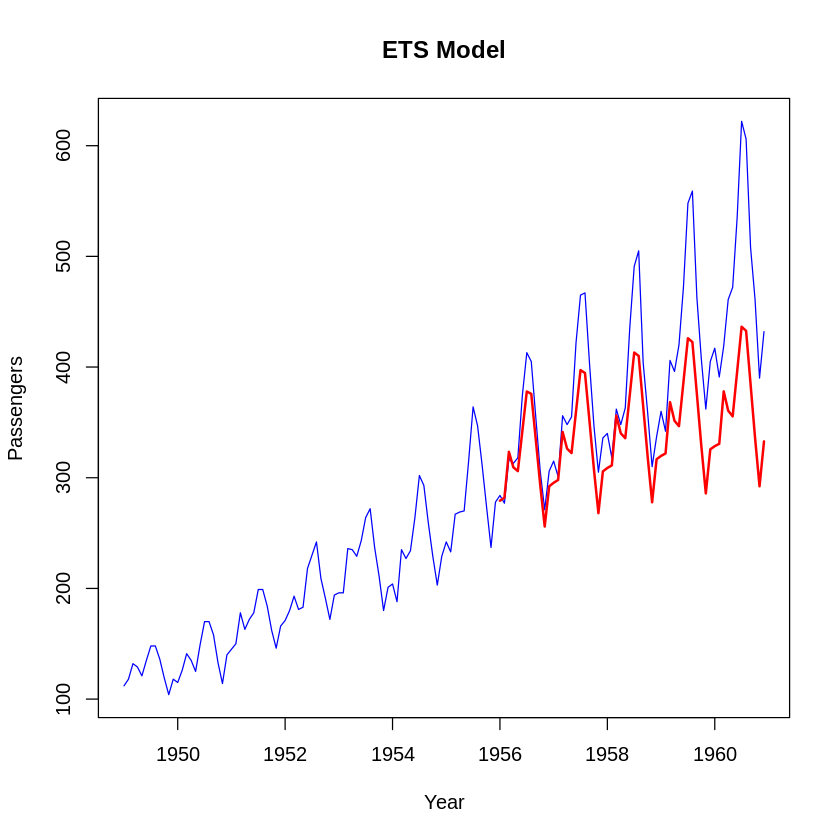

In [ ]:
plot(data, col="blue", xlab="Year", ylab="Passengers", main="ETS Model", type='l')
lines(ets_forecast$mean, col="red", lwd=2)

We're still not seeing the trend. Data needs to take population change into change. Beta is the problem here. The model isn't understand that.

- in simple seasonality, beta is constant. This is why the trend is not being captured.
- in souble seasonality, the beta changes for every x.

In [ ]:
# dshw() : instead of using single seasonality forecasting. we use double seasonality forecasting
dshw_model <- dshw(training, period1=4, period2 = 12, h=length(validation))
MAPE(dshw_model$mean, validation)*100

[1] 3.27219

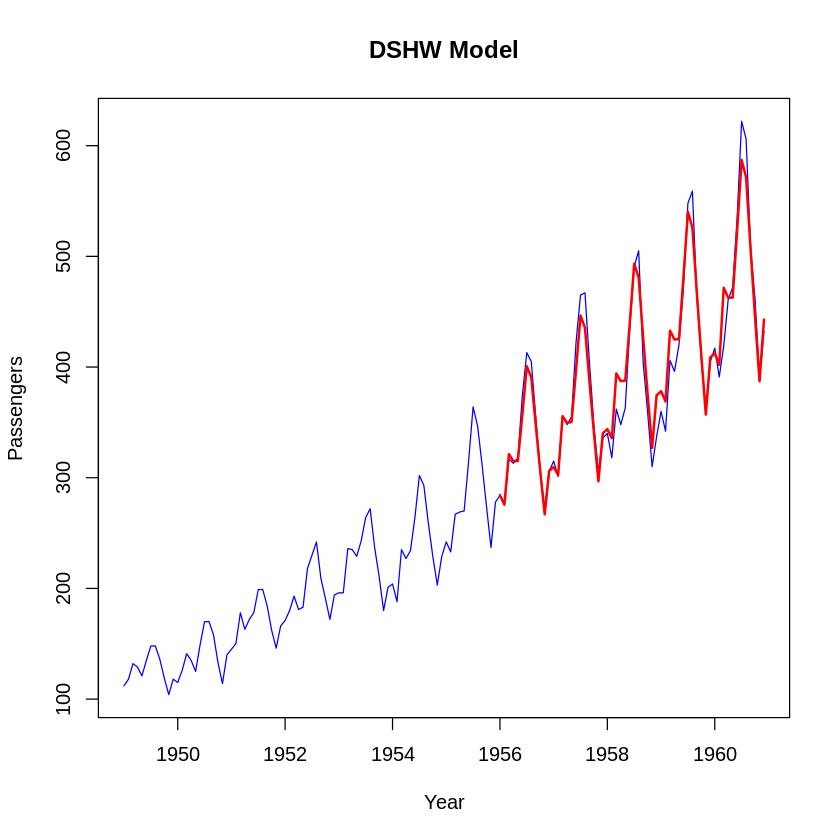

In [ ]:
plot(data, col="blue", xlab="Year", ylab="Passengers", main="DSHW Model", type='l')
lines(dshw_model$mean, col="red", lwd=2)

In [ ]:
Now the forecasting is much closer.

In [ ]:
# arima() captures a suite of different standard temporal structures in time series data
# uses brte force to test all values of p,d,q to see what's best
arima_model <- arima(training, order=c(1, 1, 0))
#MAPE(arima_model$mean, validation)*100

In [ ]:
summary(arima_model)


Call:
arima(x = training, order = c(1, 1, 0))

Coefficients:
         ar1
      0.2119
s.e.  0.1091

sigma^2 estimated as 436.8:  log likelihood = -370.1,  aic = 744.19

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE     ACF1
Training set 1.660623 20.77593 16.89832 0.5094796 8.497985 0.9726495 0.042777

In [ ]:
arima_model <- forecast(arima_model, h=length(validation))
MAPE(arima_model$mean, validation)*100

[1] 24.69807

Validation set is doing worse than in training (look at MAPE metrix for training)

In [ ]:
auto_arima <- auto.arima(training)
auto_arima <- forecast(auto_arima, h=length(validation))
MAPE(auto_arima$mean, validation)*100

[1] 6.544624

In [ ]:
summary(auto_arima)
# Look at forecasting method to see the p,d,q
# there are two p,d,q. (0,1,1) and (1,1,0)
# first is the non-seasonal part of the model. The second is the seasonal part of the model


Forecast method: ARIMA(0,1,1)(1,1,0)[12]

Model Information:
Series: training 
ARIMA(0,1,1)(1,1,0)[12] 

Coefficients:
          ma1     sar1
      -0.2591  -0.2603
s.e.   0.1296   0.1179

sigma^2 = 96.77:  log likelihood = -262.5
AIC=531   AICc=531.36   BIC=537.79

Error measures:
                   ME    RMSE      MAE       MPE    MAPE      MASE        ACF1
Training set 0.761398 8.91558 6.326126 0.2448795 2.99341 0.2369829 0.004060443

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1956       284.9928 272.3862 297.5995 265.7126 304.2731
Feb 1956       274.1706 258.4811 289.8602 250.1756 298.1657
Mar 1956       311.5547 293.2957 329.8138 283.6299 339.4796
Apr 1956       310.9516 290.4424 331.4608 279.5855 342.3177
May 1956       313.5135 290.9777 336.0492 279.0481 347.9789
Jun 1956       354.6088 330.2143 379.0033 317.3006 391.9169
Jul 1956       400.7453 374.6240 426.8666 360.7962 440.6944
Aug 1956       385.8278 358.0869 413.5687 343.4018 428.2538
Sep 19

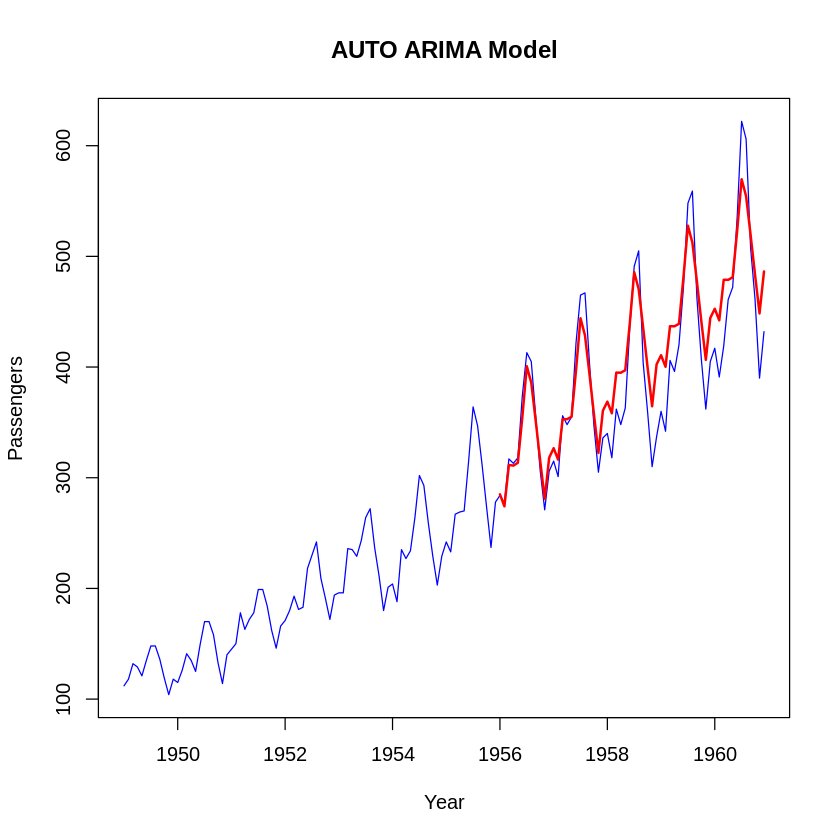

In [ ]:
plot(data, col="blue", xlab="Year", ylab="Passengers", main="AUTO ARIMA Model", type='l')
lines(auto_arima$mean, col="red", lwd=2)

`geom_smooth()` using formula = 'y ~ x'


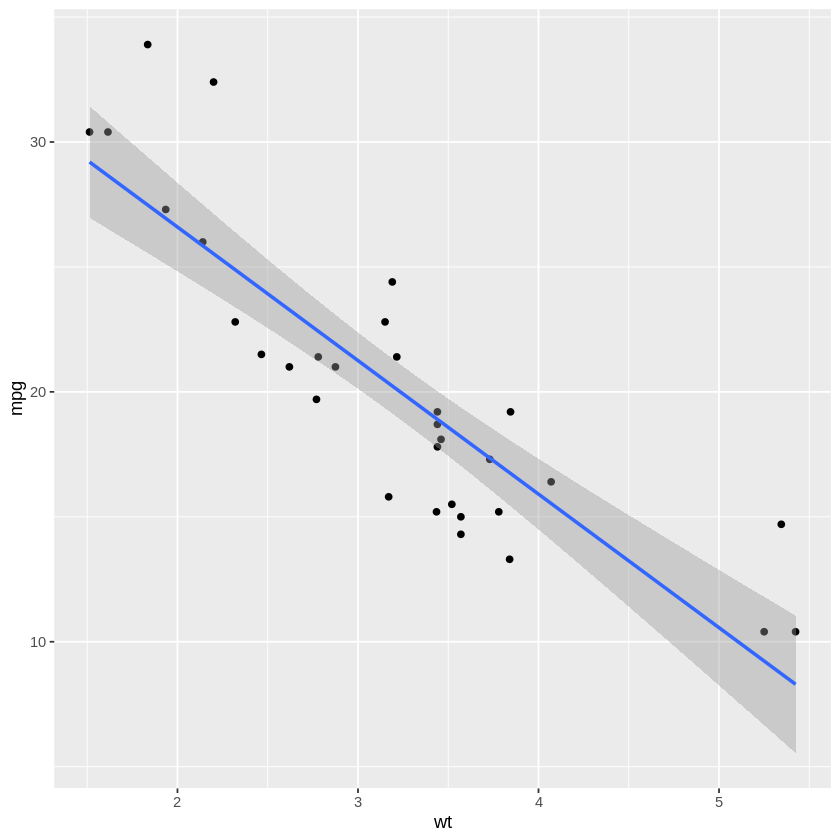

In [ ]:
library(ggplot2)
ggplot(mtcars, aes(x=wt, y=mpg)) + geom_point() + geom_smooth(method="lm")

In [ ]:
shapiro.test(mtcars$mpg)
shapiro.test(mtcars$wt)


	Shapiro-Wilk normality test

data:  mtcars$mpg
W = 0.94756, p-value = 0.1229



	Shapiro-Wilk normality test

data:  mtcars$wt
W = 0.94326, p-value = 0.09265


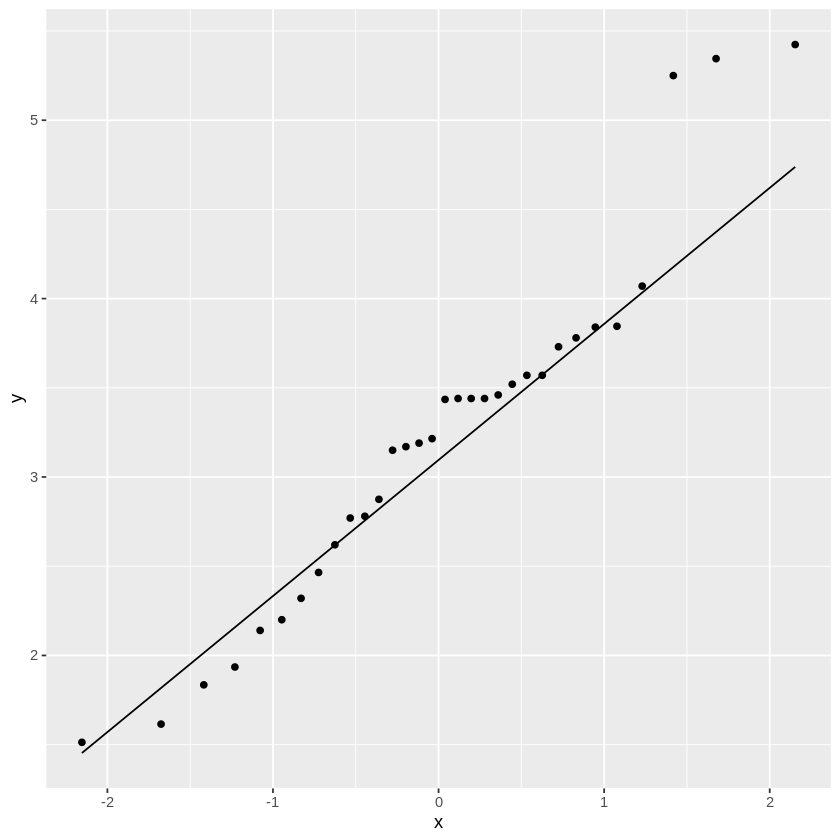

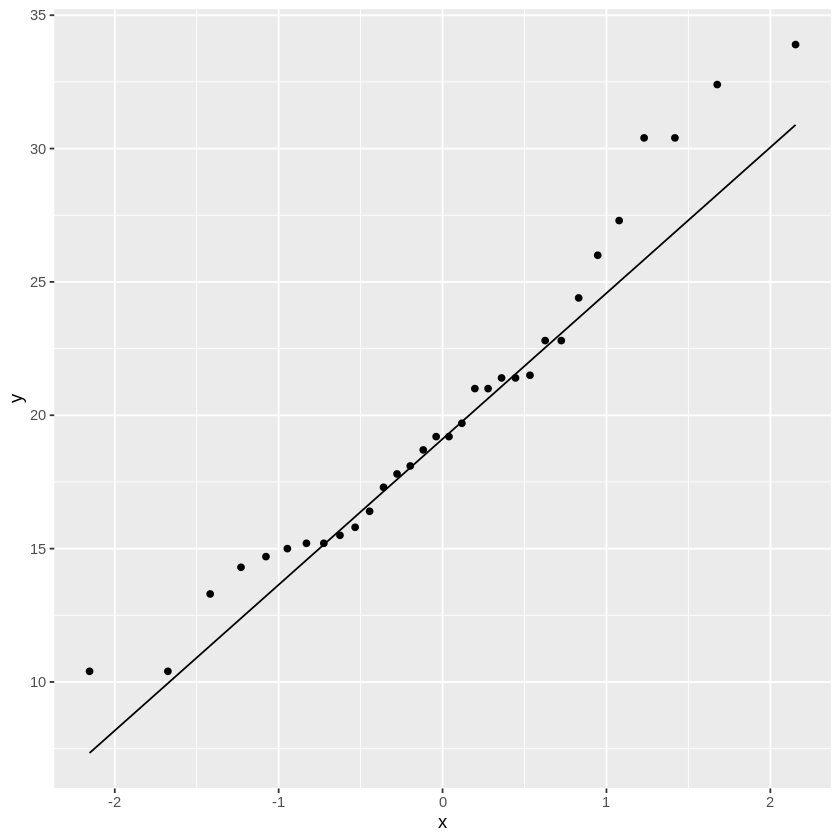

In [ ]:
ggplot(mtcars, aes(sample=wt)) + stat_qq() + stat_qq_line()
ggplot(mtcars, aes(sample=mpg)) + stat_qq() + stat_qq_line()

## pbinom function and One tailed and two tailed tests

In [ ]:
dbinom(4, size=12, prob=0.2)

[1] 0.1328756

In [ ]:
pbinom(4, size=12, prob=0.2)

[1] 0.9274445

In [ ]:
binom.test(10,30)


	Exact binomial test

data:  10 and 30
number of successes = 10, number of trials = 30, p-value = 0.09874
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.1728742 0.5281200
sample estimates:
probability of success 
             0.3333333 


In [ ]:
binom.test(10,30, alternative="less")


	Exact binomial test

data:  10 and 30
number of successes = 10, number of trials = 30, p-value = 0.04937
alternative hypothesis: true probability of success is less than 0.5
95 percent confidence interval:
 0.0000000 0.4994387
sample estimates:
probability of success 
             0.3333333 


## Coming back to correlation test

In [ ]:
cor.test(mtcars$wt, mtcars$mpg, method = "pearson")


	Pearson's product-moment correlation

data:  mtcars$wt and mtcars$mpg
t = -9.559, df = 30, p-value = 1.294e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9338264 -0.7440872
sample estimates:
       cor 
-0.8676594 


In [ ]:
cor.test(mtcars$wt, mtcars$mpg, method = "spearman")

Warning message in cor.test.default(mtcars$wt, mtcars$mpg, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  mtcars$wt and mtcars$mpg
S = 10292, p-value = 1.488e-11
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
-0.886422 


In [ ]:
cor.test(mtcars$wt, mtcars$mpg, method = "kendall")

Warning message in cor.test.default(mtcars$wt, mtcars$mpg, method = "kendall"):
“Cannot compute exact p-value with ties”



	Kendall's rank correlation tau

data:  mtcars$wt and mtcars$mpg
z = -5.7981, p-value = 6.706e-09
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.7278321 


## Testing the mean of one sample

In [ ]:
head(precip)

Mobile      Juneau     Phoenix Little Rock Los Angeles  Sacramento 
       67.0        54.7         7.0        48.5        14.0        17.2

In [ ]:
is.vector(precip)
mean(precip)

[1] TRUE

[1] 34.88571

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


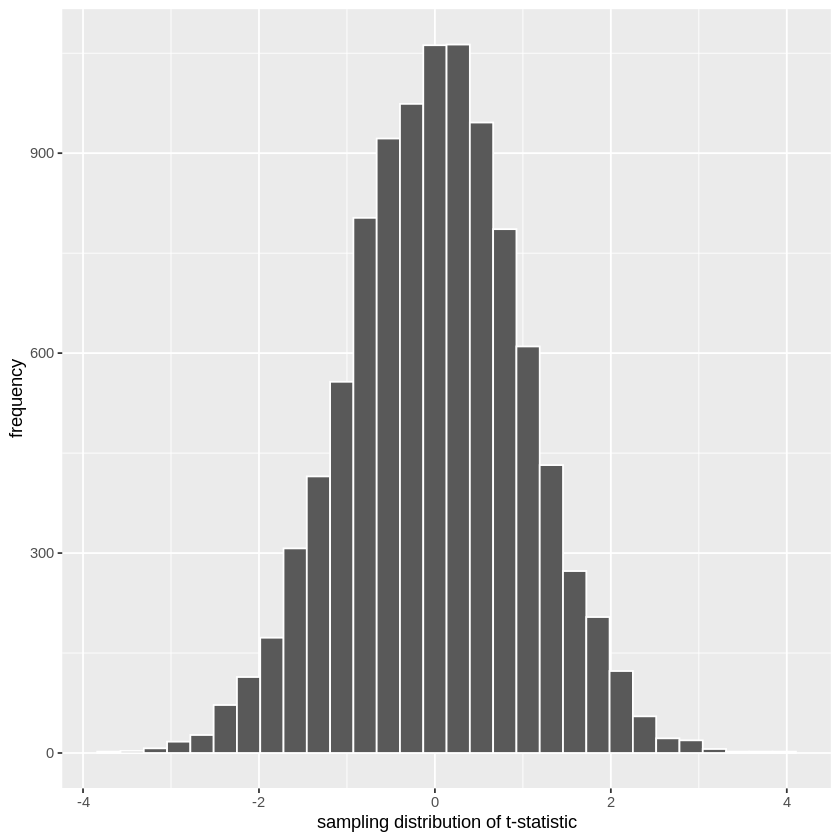

In [ ]:
# function to compute t-statistic
t.statistic <- function(thesample, thepopulation){
numerator <- mean(thesample) - mean(thepopulation)
denominator <- sd(thesample) / sqrt(length(thesample))
t.stat <- numerator / denominator
return(t.stat)
}
# make the pretend population normally distributed
# with a mean of 38
population.precipitation <- rnorm(100000, mean=38)
t.stats <- numeric(10000)
for(i in 1:10000){
a.sample <- sample(population.precipitation, 70)
t.stats[i] <- t.statistic(a.sample, population.precipitation)
}
# plot
library(ggplot2)
tmpdata <- data.frame(vals=t.stats)
qplot(vals, data=tmpdata, geom="histogram",
color=I("white"),
xlab="sampling distribution of t-statistic",
ylab="frequency")


In [ ]:
t.statistic(precip, population.precipitation)

[1] -1.900894

In [ ]:
qt(.025, df=69)

[1] -1.994945

In [ ]:
t.test(precip, mu=38)


	One Sample t-test

data:  precip
t = -1.901, df = 69, p-value = 0.06148
alternative hypothesis: true mean is not equal to 38
95 percent confidence interval:
 31.61748 38.15395
sample estimates:
mean of x 
 34.88571 


In [ ]:
t.test(precip, mu=38, alternative="less")


	One Sample t-test

data:  precip
t = -1.901, df = 69, p-value = 0.03074
alternative hypothesis: true mean is less than 38
95 percent confidence interval:
     -Inf 37.61708
sample estimates:
mean of x 
 34.88571 


## Testing two means

In [ ]:
mean(mtcars$mpg[mtcars$am==0])
mean(mtcars$mpg[mtcars$am==1])

[1] 17.14737

[1] 24.39231

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


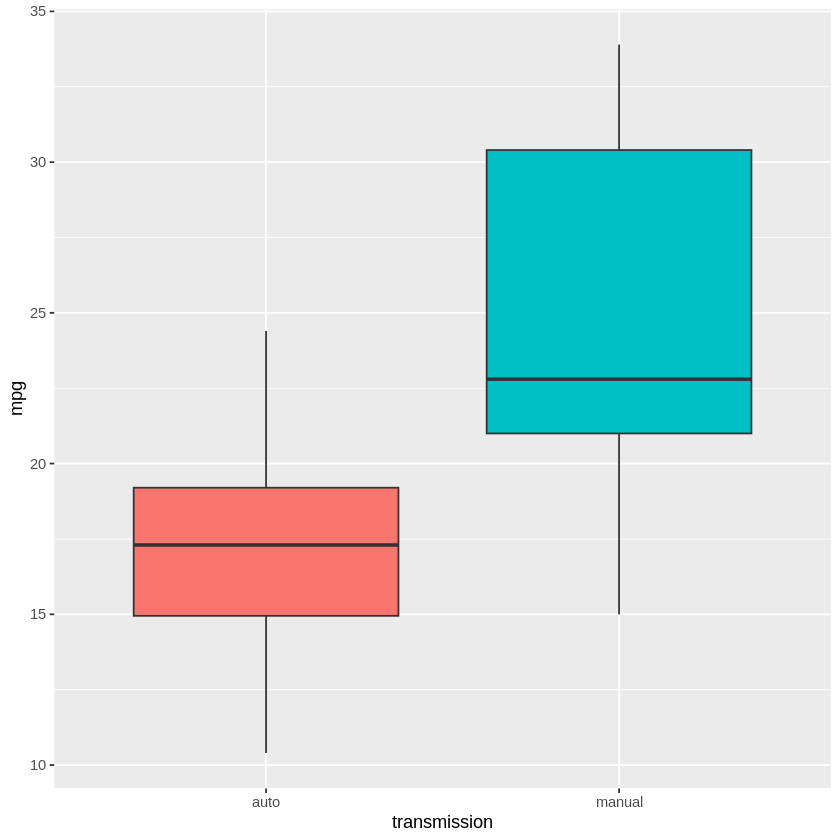

In [ ]:
mtcars.copy <- mtcars
# make new column with better labels
mtcars.copy$transmission <- ifelse(mtcars$am==0, "auto", "manual")
mtcars.copy$transmission <- factor(mtcars.copy$transmission)
qplot(transmission, mpg, data=mtcars.copy,geom="boxplot", fill=transmission) + guides(fill=FALSE)


In [ ]:
automatic.mpgs <- mtcars$mpg[mtcars$am==0]
manual.mpgs <- mtcars$mpg[mtcars$am==1]
t.test(automatic.mpgs, manual.mpgs, alternative="less")


	Welch Two Sample t-test

data:  automatic.mpgs and manual.mpgs
t = -3.7671, df = 18.332, p-value = 0.0006868
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -3.913256
sample estimates:
mean of x mean of y 
 17.14737  24.39231 


In [ ]:
set.seed(16)
t.test(rnorm(1000000,mean=10), rnorm(1000000, mean=10))


	Welch Two Sample t-test

data:  rnorm(1e+06, mean = 10) and rnorm(1e+06, mean = 10)
t = -2.1466, df = 2e+06, p-value = 0.03183
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0058104638 -0.0002640601
sample estimates:
mean of x mean of y 
 9.997916 10.000954 


## Cohen's d

In [ ]:
install.packages("effsize")
library(effsize)
cohen.d(automatic.mpgs, manual.mpgs)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




Cohen's d

d estimate: -1.477947 (large)
95 percent confidence interval:
    lower     upper 
-2.304209 -0.651685 


## Testing more than two means

In [ ]:
install.packages("car")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’




In [ ]:
library(car)
head(WeightLoss)

Loading required package: carData



,group,wl1,wl2,wl3,se1,se2,se3
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,Control,4,3,3,14,13,15
2,Control,4,4,3,13,14,17
3,Control,4,3,1,17,12,16
4,Control,3,2,1,11,11,12
5,Control,5,3,2,16,15,14
6,Control,6,5,4,17,18,18


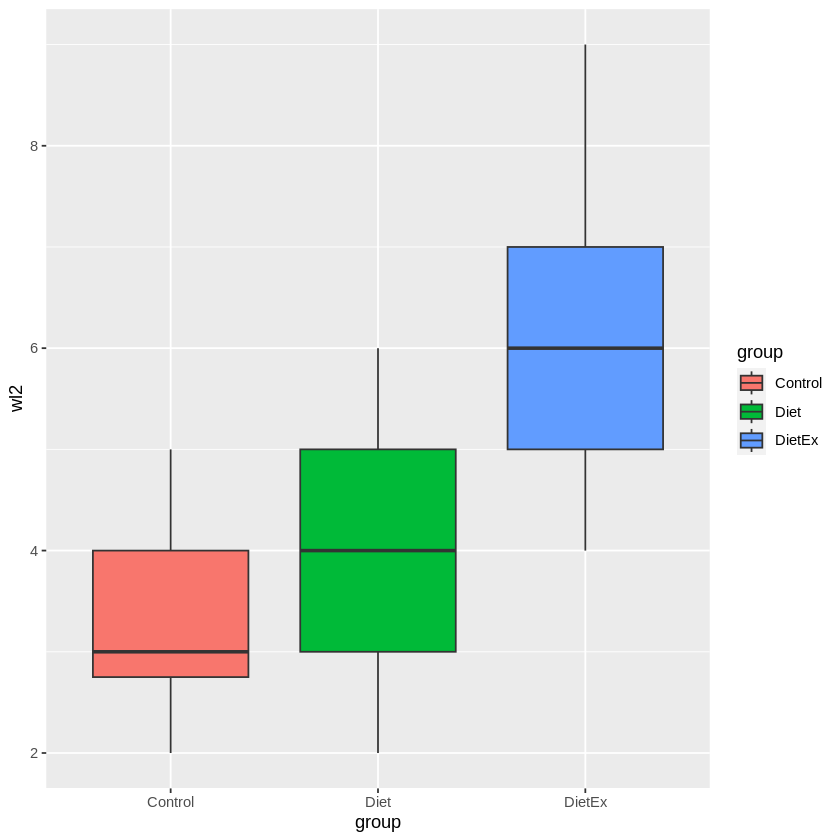

In [ ]:
qplot(group, wl2, data=WeightLoss, geom="boxplot", fill=group)

## ANOVA

In [ ]:
the.anova <- aov(wl2 ~ group, data=WeightLoss)
summary(the.anova)

            Df Sum Sq Mean Sq F value   Pr(>F)    
group        2  45.28  22.641   13.37 6.49e-05 ***
Residuals   31  52.48   1.693                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Pairwise t Test

In [ ]:
pairwise.t.test(WeightLoss$wl2, as.vector(WeightLoss$group))


	Pairwise comparisons using t tests with pooled SD 

data:  WeightLoss$wl2 and as.vector(WeightLoss$group) 

       Control Diet   
Diet   0.28059 -      
DietEx 7.1e-05 0.00091

P value adjustment method: holm 

## Testing independence of proportions

In [ ]:
# The chi-square test function takes a cross-tabulation
# which UCBAdmissions already is. I am converting it from
# and back so that you, dear reader, can learn how to do
# this with other data that isn't already in cross-tabulation
# form
ucba <- as.data.frame(UCBAdmissions)
head(ucba)

,Admit,Gender,Dept,Freq
,<fct>,<fct>,<fct>,<dbl>
1,Admitted,Male,A,512
2,Rejected,Male,A,313
3,Admitted,Female,A,89
4,Rejected,Female,A,19
5,Admitted,Male,B,353
6,Rejected,Male,B,207


In [ ]:
# create cross-tabulation
cross.tab <- xtabs(Freq ~ Gender+Admit, data=ucba)
chisq.test(cross.tab)


	Pearson's Chi-squared test with Yates' continuity correction

data:  cross.tab
X-squared = 91.61, df = 1, p-value < 2.2e-16


[1] 20 18

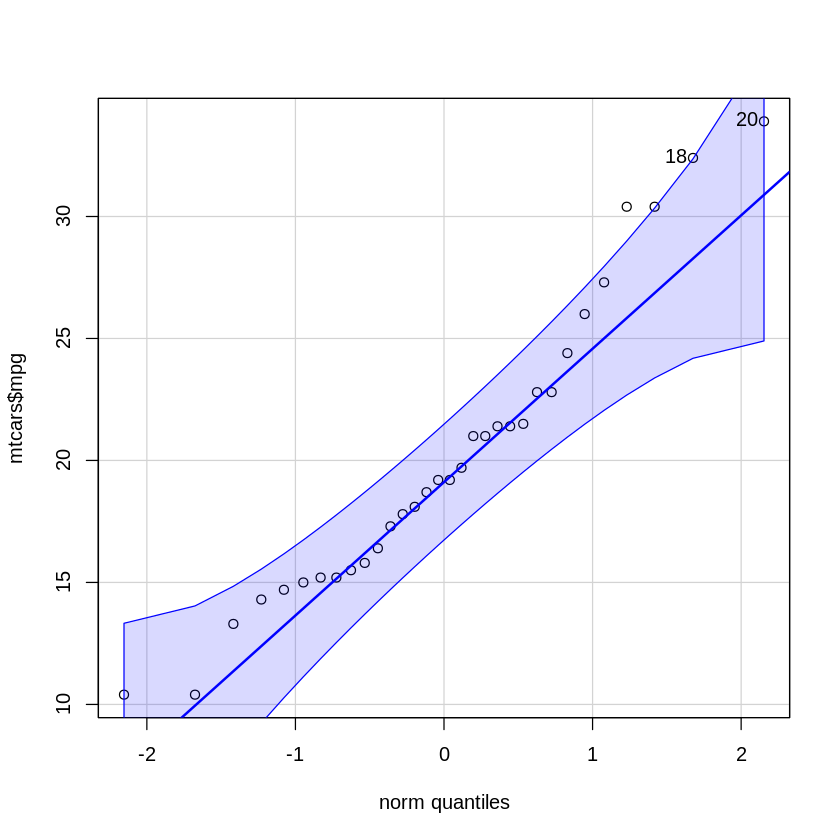

In [ ]:
qqPlot(mtcars$mpg)

In [ ]:
shapiro.test(mtcars$mpg)


	Shapiro-Wilk normality test

data:  mtcars$mpg
W = 0.94756, p-value = 0.1229


In [ ]:
the.anova <- aov(wl2 ~ group, data=WeightLoss)
shapiro.test(the.anova$residuals)


	Shapiro-Wilk normality test

data:  the.anova$residuals
W = 0.96937, p-value = 0.4444


In [ ]:
wilcox.test(automatic.mpgs, manual.mpgs)

Warning message in wilcox.test.default(automatic.mpgs, manual.mpgs):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  automatic.mpgs and manual.mpgs
W = 42, p-value = 0.001871
alternative hypothesis: true location shift is not equal to 0


In [ ]:
kruskal.test(wl2 ~ group, data=WeightLoss)


	Kruskal-Wallis rank sum test

data:  wl2 by group
Kruskal-Wallis chi-squared = 14.747, df = 2, p-value = 0.0006275
